In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

import torch
import numpy as np
from torch import nn
from Sparse import ReLUWithSparsity2d, ReLUWithSparsity

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor

In [2]:
transform = Compose([ToTensor()])
dataset = MNIST('../dataset', transform=transform, download=True)
loader = DataLoader(dataset, batch_size=128)

In [3]:
model = nn.Sequential(*[
    nn.Conv2d(1, 12, 3, padding=1),
    ReLUWithSparsity2d(beta=1e2, rho=0.05),
    # ReLUWithSparsity(beta=1e-1, rho=0.33),
    # nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    # nn.BatchNorm2d(12),
    nn.Conv2d(12, 24, 3, padding=1),
    ReLUWithSparsity2d(beta=1e2, rho=0.05),
    # ReLUWithSparsity(beta=1e-1, rho=0.33),
    # nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    # nn.BatchNorm2d(24),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(24, 12, 3, padding=1),
    nn.ReLU(inplace=True),
    # nn.BatchNorm2d(12),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(12, 1, 3, padding=1),
    nn.ReLU(inplace=True),
])


In [4]:
from tqdm import tqdm

n_epoch = 3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

for epoch in epoch_iterator:
    for input, _ in loader:
        input = input.to(device)

        out = model(input)
        loss = criterion(out, input)

        epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 3/3 [00:22<00:00,  7.51s/epoch, tls=0.0048]


In [5]:
from torchvision.transforms import ToPILImage

to_img = ToPILImage()
img_in = to_img(input[0].cpu())
img_out = to_img(out[0].cpu())

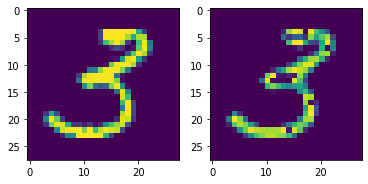

In [6]:
from matplotlib import pyplot as plt
plt.subplot(1,2,1)   
plt.imshow(img_in)
plt.subplot(1,2,2)   
plt.imshow(img_out)
plt.show()

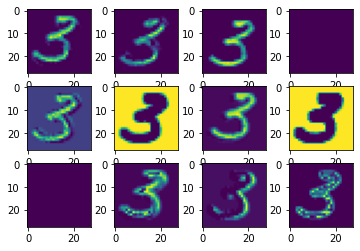

In [7]:
test_out = model[:2](input)

for i in range(3):
    for j in range(4):
        plt.subplot(3,4, i*4 + (j+1))        
        plt.imshow(to_img(test_out[0,i*4 + (j)].cpu()))

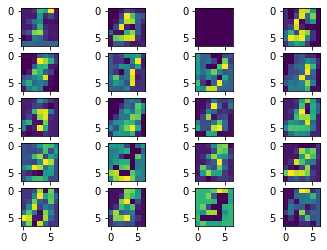

In [12]:
test_out = model[:6](input)
for i in range(5):
    for j in range(4):
        plt.subplot(5,4, i*4 + (j+1))        
        plt.imshow(to_img(test_out[0,i*4 + (j)].cpu()))

In [13]:

(test_out[0]>0).sum()

tensor(1039, device='cuda:0')

In [14]:
test_out[0].shape

torch.Size([24, 7, 7])

In [15]:
24*14*14

4704